In [1]:
import json
import requests
import math

from datetime import datetime
from datetime import timedelta

from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

torch.cuda.is_available()

True

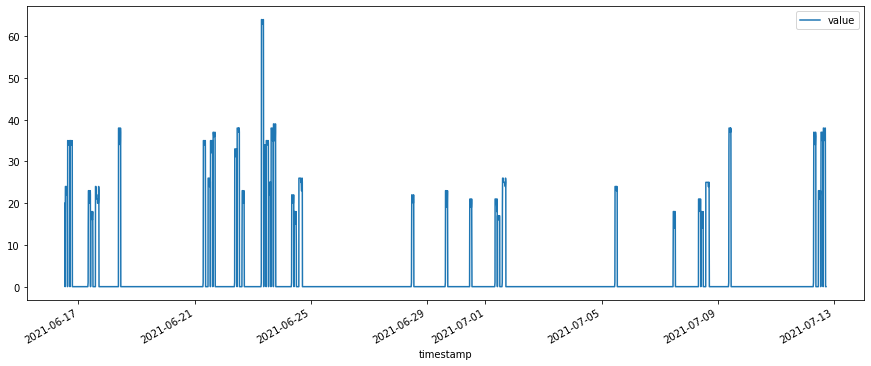

In [2]:
countDataOrig = pd.read_json("timeseries.json")
countDataOrig['timestamp'].min(),countDataOrig['timestamp'].max()
countDataOrig = countDataOrig.sort_values('timestamp')
countDataOrig.isnull().sum()
countDataOrig = countDataOrig.groupby('timestamp')
countDataOrig = countDataOrig.max().reset_index()
countDataOrig = countDataOrig.set_index('timestamp')
countDataOrig.plot(figsize=(15,6))
plt.show()

Resample Data

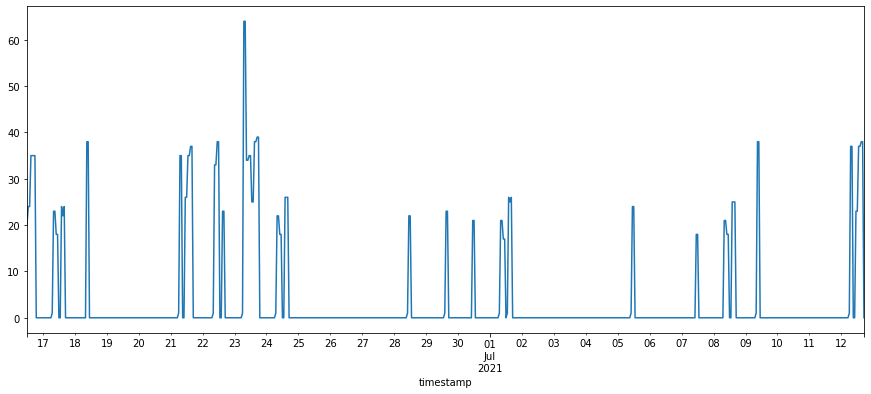

In [30]:
ts = countDataOrig['value'].resample('T').bfill()
countData = ts.resample('30T').mean()
countData = ts.resample('H').max()
countData.plot(figsize=(15,6))
plt.show()

Truncate Data

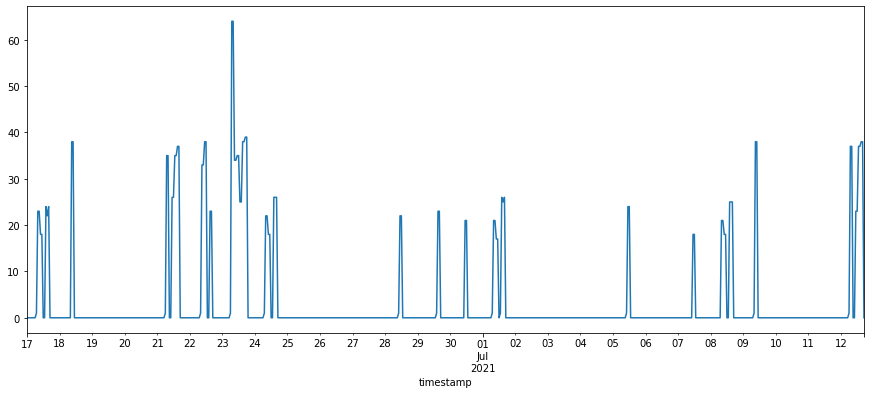

In [31]:
start_date = datetime(2021,6,17)
end_date = datetime(2021,7,11)
lim_countData = countData[start_date:]
lim_countData.plot(figsize=(15,6))
plt.show()

In [87]:
def rbf(x, i,alpha, t):
    term = x-i
    term = np.power(term,2)
    term = -(1/(2*alpha))*term
    term = np.exp(term)
    term = np.mod(term, t)
    return term


def augmentTimeSeries(ts):
    ts.insert(1,"time_idx",(((ts.index-first_data).days*24*60+ts.index.hour*60+ts.index.minute)/60).astype(int),True)
    ts.insert(1,"room_number",1,True)
    #Weekly Features
    ts["weekday"] = ts.index.dayofweek.astype(str).astype("category")
    ts["hour"] = ts.index.hour.astype(str).astype("category")
    ts["timeinterval"] = ((ts.index.dayofweek*24*60+ts.index.hour*60+ts.index.minute)/60).astype(str).astype("category")
    #ts["value"] = np.log1p(ts["value"])
    return ts

In [88]:
data = lim_countData
first_data = lim_countData.index.min()
df_w_features = data.to_frame()


#Weekly Features

#for i in range(24):
    #df_w_features["hour"+str(i)] = data.index.hour.map(lambda x: rbf(x,i,0.1, 24))



#for i in range(672):
 #   df_w_features["timeinterval"+str(i)] = ((data.index.dayofweek*24*60+data.index.hour*60+data.index.minute)/15).map(lambda x: rbf(x,i,2,672))


df_w_features = augmentTimeSeries(df_w_features)
df_w_features


,value,room_number,time_idx,weekday,hour,timeinterval
timestamp,,,,,,
2021-06-17 00:00:00,0,1,0,3,0,72.0
2021-06-17 01:00:00,0,1,1,3,1,73.0
2021-06-17 02:00:00,0,1,2,3,2,74.0
2021-06-17 03:00:00,0,1,3,3,3,75.0
2021-06-17 04:00:00,0,1,4,3,4,76.0
...,...,...,...,...,...,...
2021-07-12 13:00:00,37,1,613,0,13,13.0
2021-07-12 14:00:00,37,1,614,0,14,14.0
2021-07-12 15:00:00,38,1,615,0,15,15.0


In [89]:
max_prediction_length = 168
max_encoder_length = 168

data = df_w_features

training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=["room_number"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["weekday","hour","timeinterval"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["value"],
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [92]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)

((actuals).double() - (baseline_predictions).double()).abs().mean().item()

0.9880952380952381

In [93]:
df_w_features.describe()

,value,room_number,time_idx
count,618.000000,618.0,618.000000
mean,3.543689,1.0,308.500000
std,9.962110,0.0,178.545512
min,0.000000,1.0,0.000000
25%,0.000000,1.0,154.250000
50%,0.000000,1.0,308.500000
75%,0.000000,1.0,462.750000
max,64.000000,1.0,617.000000


In [94]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Number of parameters in network: 20.3k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 2.9 K 
3  | prescalers                         | ModuleDict                      | 48    
4  | static_variable_selection          | VariableSelectionNetwork        | 528   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 972   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:   8%|▊         | 8/100 [00:02<00:26,  3.48it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  12%|█▏        | 12/100 [00:03<00:23,  3.70it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  16%|█▌        | 16/100 [00:04<00:22,  3.76it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  20%|██        | 20/100 [00:05<00:21,  3.69it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  24%|██▍       | 24/100 [00:07<00:22,  3.37it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  28%|██▊       | 28/100 [00:08<00:20,  3.45it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  32%|███▏      | 32/100 [00:09<00:19,  3.52it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  36%|███▌      | 36/100 [00:11<00:18,  3.40it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  40%|████      | 40/100 [00:12<00:17,  3.43it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  44%|████▍     | 44/100 [00:13<00:15,  3.52it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  48%|████▊     | 48/100 [00:14<00:14,  3.68it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  52%|█████▏    | 52/100 [00:15<00:13,  3.58it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  56%|█████▌    | 56/100 [00:17<00:12,  3.46it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  60%|██████    | 60/100 [00:18<00:11,  3.55it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  64%|██████▍   | 64/100 [00:19<00:09,  3.67it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  68%|██████▊   | 68/100 [00:20<00:08,  3.75it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  72%|███████▏  | 72/100 [00:21<00:07,  3.76it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  76%|███████▌  | 76/100 [00:23<00:06,  3.79it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  80%|████████  | 80/100 [00:24<00:05,  3.73it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  84%|████████▍ | 84/100 [00:25<00:04,  3.68it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  88%|████████▊ | 88/100 [00:26<00:03,  3.55it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  92%|█████████▏| 92/100 [00:27<00:02,  3.69it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr:  96%|█████████▌| 96/100 [00:28<00:01,  3.76it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


Finding best initial lr: 100%|██████████| 100/100 [00:30<00:00,  3.74it/s]Restored states from the checkpoint file at f:\IOT\lr_find_temp_model.ckpt


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
suggested learning rate: 0.20892961308540398


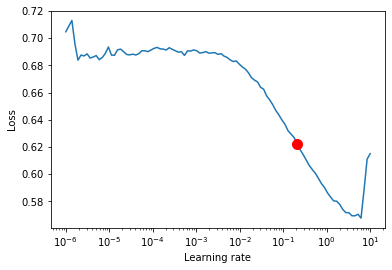

<ipython-input-95-63c2f02472b8>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [95]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [96]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.08,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Number of parameters in network: 20.3k


In [97]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 2.9 K 
3  | prescalers                         | ModuleDict                      | 48    
4  | static_variable_selection          | VariableSelectionNetwork        | 528   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 972   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Global seed set to 42


Epoch 0:   0%|          | 0/5 [00:00<?, ?it/s] 

F:\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s, loss=0.749, v_num=9, val_loss=0.727, train_loss_step=0.757, train_loss_epoch=0.756]

Finding best initial lr: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Epoch 29: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s, loss=0.398, v_num=9, val_loss=0.387, train_loss_step=0.373, train_loss_epoch=0.381]


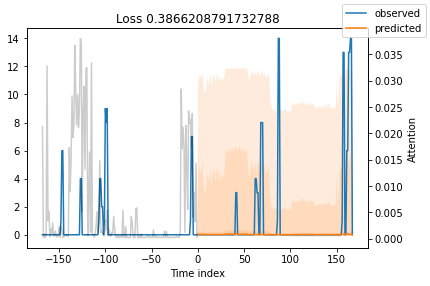

In [98]:
raw_predictions, x = tft.predict(val_dataloader, mode="raw", return_x=True)
tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);

In [102]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)
(np.expm1(actuals).double() - np.expm1(predictions).double()).abs().mean()


tensor(39226.1716, dtype=torch.float64)

In [16]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=30,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2021-07-14 20:26:31,243] A new study created in memory with name: no-name-717e4576-df53-40f9-9613-ea79f4350512
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
F:\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
F:\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
[I 2021-07-14 20:28:18,950] T

{'gradient_clip_val': 0.37821000389363896, 'hidden_size': 12, 'dropout': 0.18532735103249087, 'hidden_continuous_size': 8, 'attention_head_size': 1, 'learning_rate': 0.0756383247825722}


In [17]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [52]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
((actuals).double() - (predictions).double()).abs().mean()

tensor(0.4685, dtype=torch.float64)

In [27]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

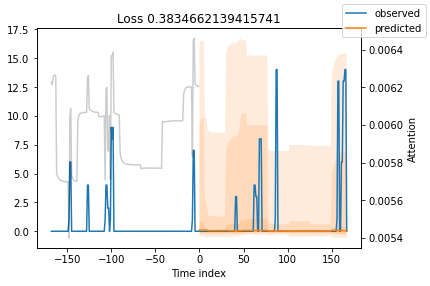

In [29]:
for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);
